## Dependencies

In [1]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS:  1


# Model parameters

In [4]:
# base_model_path = '/kaggle/input/efficientnet/'
dataset_path = 'melanoma-256x256'

config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 64,
  "EPOCHS": 20,
  "LEARNING_RATE": 3e-4, 
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
#   "BASE_MODEL_PATH": base_model_path + 'efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5',
  "BASE_MODEL_PATH": 'imagenet',
  "DATASET_PATH": dataset_path
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 64,
 'EPOCHS': 20,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 5,
 'N_FOLDS': 5,
 'BASE_MODEL_PATH': 'imagenet',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(dataset_path)
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [7]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 2e-05


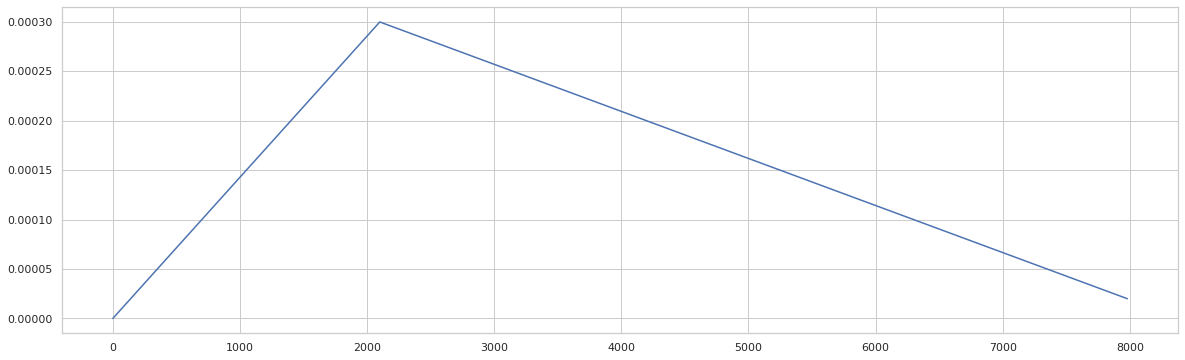

In [8]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 26880 // config['BATCH_SIZE'] #(len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, step_size)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get('resnet18')
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_PATH'], 
                           include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [10]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
#     tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    
    ### Data
    train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    train_size = count_data_items(train_filenames)

    step_size = train_size // config['BATCH_SIZE']

    # Train model
    model_path = f'model_fold_{n_fold}.h5'
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        
        lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                 total_steps=total_steps, warmup_steps=warmup_steps, 
                                                 hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                 lr_max=lr_max, lr_min=lr_min)
        
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                      metrics=[metrics.AUC()])
    
    history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                               batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es], 
                        verbose=2).history
    
    history_list.append(history)
    
    # Make predictions
    preds = model.predict(image_data)
    name_preds = dict(zip(image_names, preds.reshape(len(preds))))
    k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
    
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
    valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
    k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1
44924928/44920640 [==============================] - 1s 0us/step
Epoch 1/20
388/388 - 111s - loss: 0.3441 - auc: 0.5742 - val_loss: 0.2352 - val_auc: 0.4929
Epoch 2/20
388/388 - 110s - loss: 0.1705 - auc: 0.7966 - val_loss: 0.1717 - val_auc: 0.6084
Epoch 3/20
388/388 - 110s - loss: 0.1695 - auc: 0.8177 - val_loss: 0.1710 - val_auc: 0.7164
Epoch 4/20
388/388 - 110s - loss: 0.1670 - auc: 0.8332 - val_loss: 0.1664 - val_auc: 0.8579
Epoch 5/20
388/388 - 110s - loss: 0.1689 - auc: 0.8301 - val_loss: 0.1759 - val_auc: 0.6152
Epoch 6/20
388/388 - 110s - loss: 0.1677 - auc: 0.8398 - val_loss: 0.1693 - val_auc: 0.8298
Epoch 7/20
388/388 - 110s - loss: 0.1654 - auc: 0.8572 - val_loss: 0.1675 - val_auc: 0.8138
Epoch 8/20
388/388 - 109s - loss: 0.1659 - auc: 0.8728 - val_loss: 0.1655 - val_auc: 0.8771
Epoch 9/20
388/388 - 110s - loss: 0.1641 - auc: 0.8725 - val_loss: 0.1646 - val_auc: 0.8175
Epoch 10/20
388/388 - 110s - loss: 0.1637 - auc: 0.8741 - val_loss: 0.1659 - val_auc: 0.8378
Epoch

## Model loss graph

Fold: 1


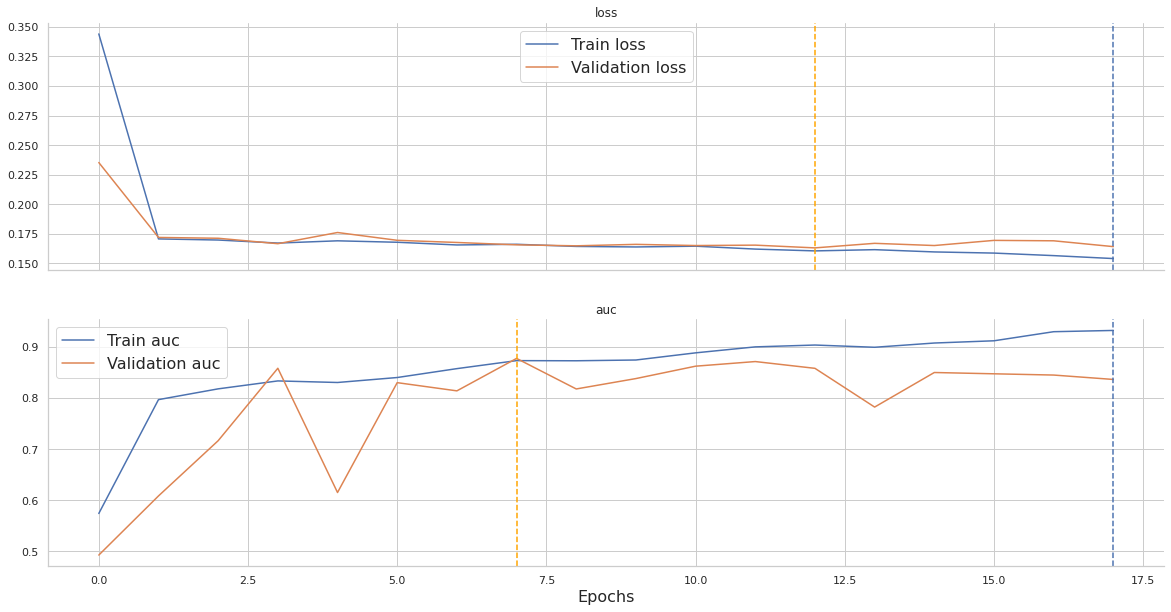

Fold: 2


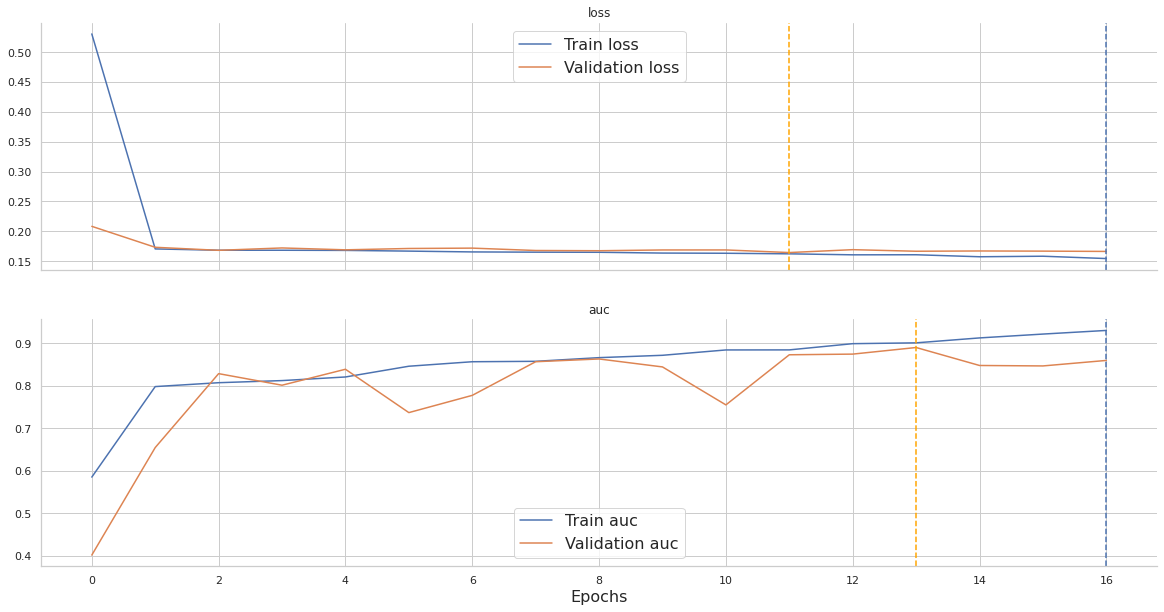

Fold: 3


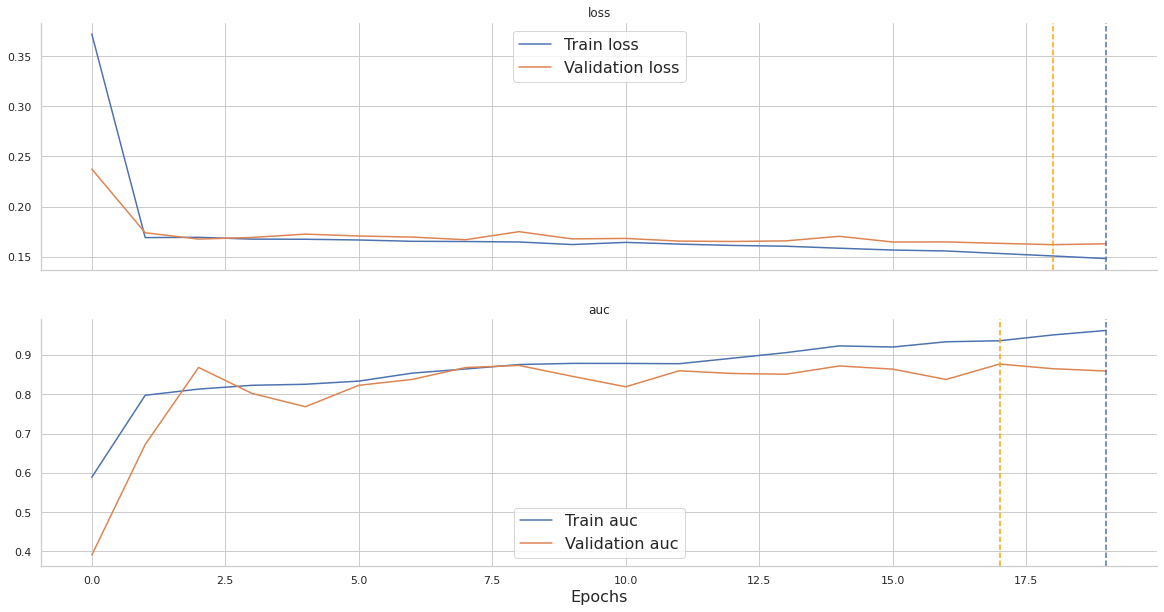

Fold: 4


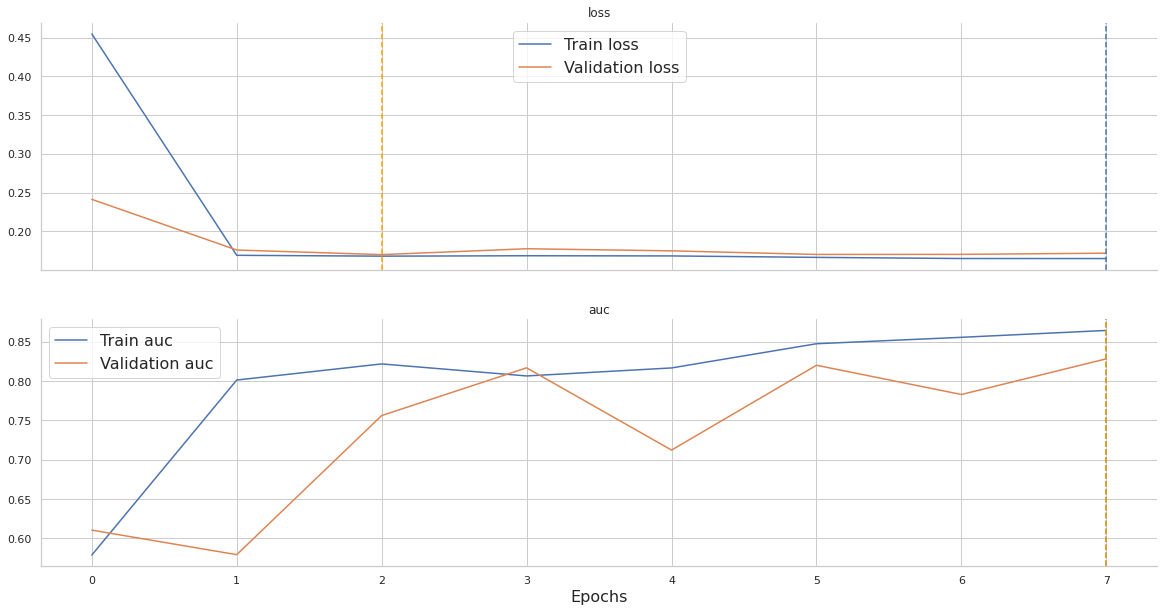

Fold: 5


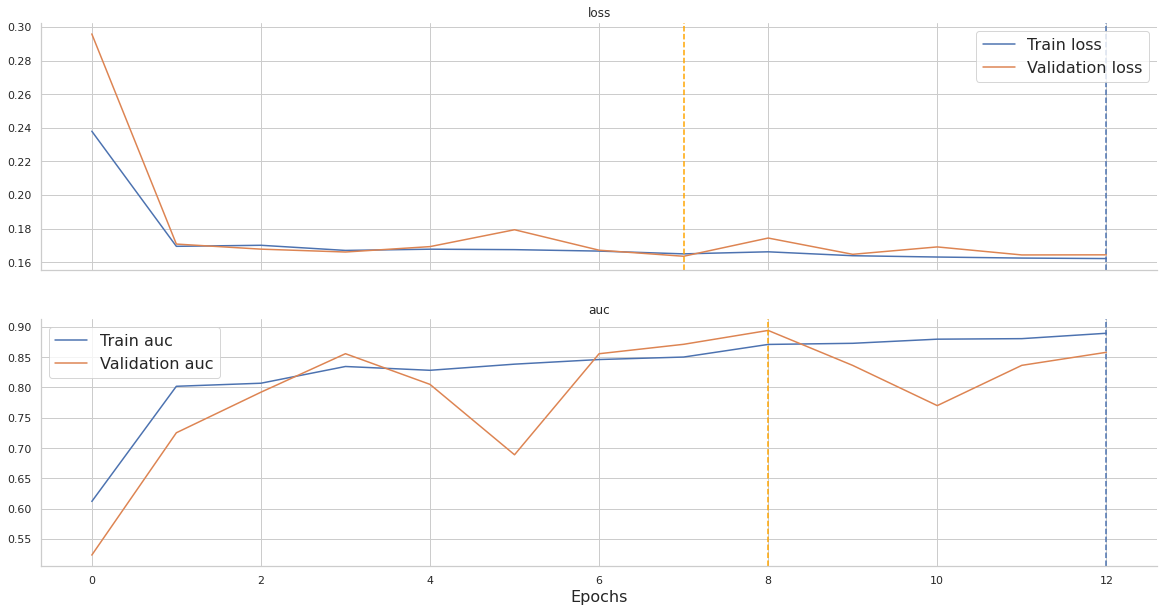

In [11]:
for n_fold in range(config['N_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

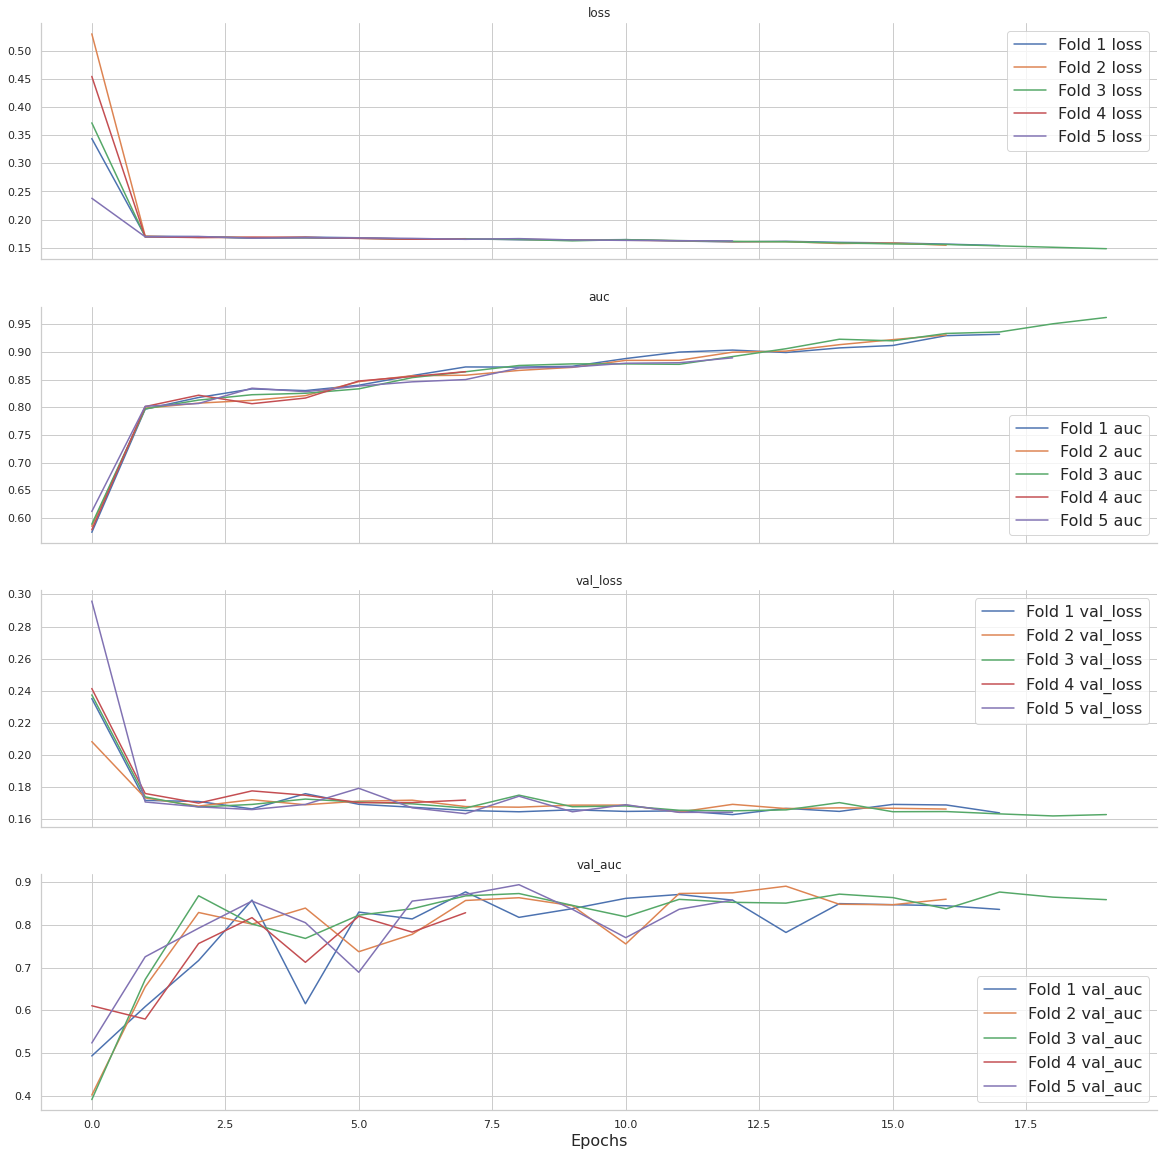

In [12]:
plot_metrics_agg(history_list, config['N_FOLDS'])

# Model evaluation

In [13]:
display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.906409,0.844973,0.061437,0.935373,0.859879,0.934709,0.876706,0.980108,0.854856,0.795324,0.760185,0.886532,0.873238
Accuracy,0.984389,0.982523,0.001866,0.983657,0.982979,0.983242,0.982617,0.990079,0.982456,0.982506,0.981944,0.982462,0.982617
Precision,0.913961,0.358696,0.555265,0.849057,0.500000,0.848485,0.750000,0.872263,0.543478,1.000000,0.000000,1.000000,0.000000
Recall,0.135721,0.055376,0.080345,0.101580,0.028369,0.059072,0.027273,0.507431,0.221239,0.002119,0.000000,0.008403,0.000000
F1-score,0.190882,0.084158,0.106725,0.181452,0.053691,0.110454,0.052632,0.641611,0.314465,0.004228,0.000000,0.016667,0.000000
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [14]:
display(evaluate_model_Subset(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.906409,0.844973,0.061437,0.935373,0.859879,0.934709,0.876706,0.980108,0.854856,0.795324,0.760185,0.886532,0.873238
male,0.908498,0.858977,0.049521,0.935227,0.878406,0.937740,0.872606,0.979808,0.877254,0.798472,0.795035,0.891245,0.871583
female,0.901781,0.818656,0.083125,0.933538,0.829920,0.929463,0.873789,0.979805,0.804327,0.791183,0.712608,0.874916,0.872638
head/neck,0.894376,0.823730,0.070646,0.921923,0.870698,0.930015,0.838548,0.984268,0.828173,0.761267,0.793885,0.874409,0.787348
upper extremity,0.898041,0.833100,0.064941,0.945662,0.853383,0.936759,0.851991,0.982289,0.836691,0.754868,0.750744,0.870629,0.872692
lower extremity,0.873870,0.811937,0.061933,0.906250,0.789594,0.896448,0.825469,0.970032,0.797273,0.748566,0.801428,0.848054,0.845920
torso,0.926763,0.869959,0.056804,0.950818,0.897843,0.949714,0.930121,0.981987,0.881807,0.839522,0.738850,0.911774,0.901175
0 <= age < 26,0.852412,0.780557,0.071854,0.889006,0.760839,0.876596,0.838167,0.957727,0.747602,0.719655,0.643231,0.819075,0.912946
26 <= age < 40,0.876261,0.800827,0.075434,0.898284,0.891430,0.898381,0.845490,0.983512,0.861249,0.759131,0.541887,0.841996,0.864079


# Confusion matrix

Fold: 1


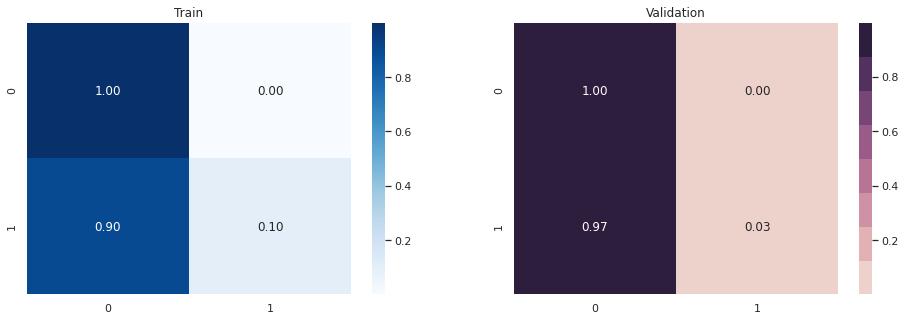

Fold: 2


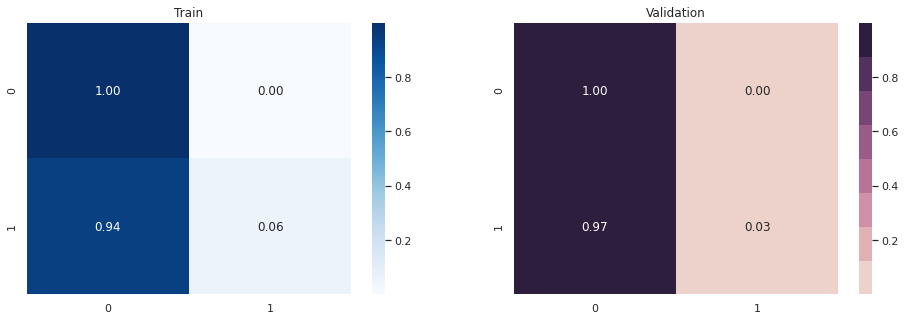

Fold: 3


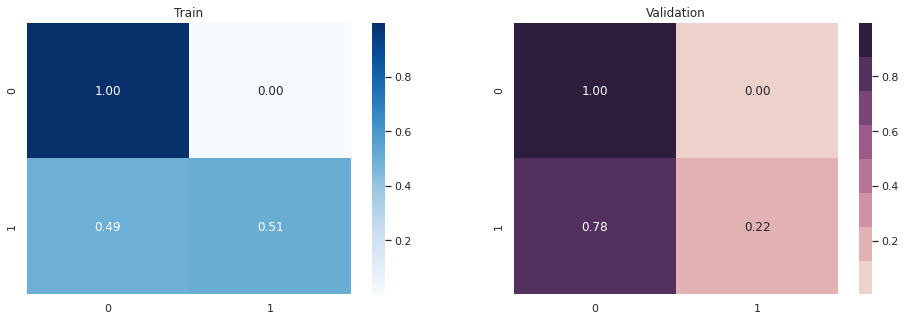

Fold: 4


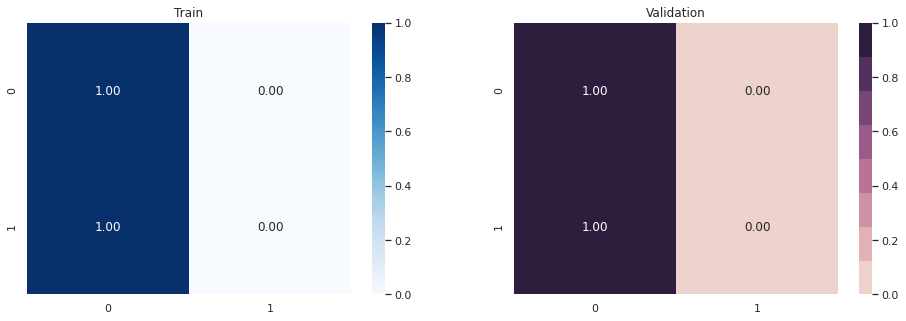

Fold: 5


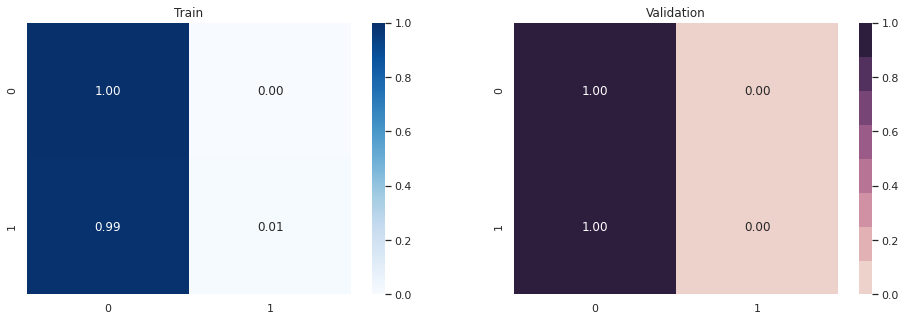

In [15]:
for n_fold in range(config['N_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [16]:
k_fold['pred'] = 0
for n_fold in range(config['N_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.022522,0.023947,0.027752,0.016409,0.022350,0.022151
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.028247,0.027715,0.018523,0.031547,0.031253,0.032195
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.025122,0.022983,0.023970,0.027379,0.022566,0.028713
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.023274,0.029498,0.022012,0.025273,0.005384,0.034201
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.023300,0.025080,0.021132,0.022807,0.022576,0.024906
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.024416,0.023555,0.024123,0.028489,0.017082,0.028831
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.030129,0.030114,0.025444,0.023718,0.047011,0.024356
7,ISIC_0075663,female,35.0,torso,unknown,0,0.037520,0.026553,0.023746,0.011203,0.062864,0.063236
8,ISIC_0075914,male,30.0,torso,unknown,0,0.028157,0.020918,0.027440,0.029146,0.041686,0.021594
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.033831,0.028991,0.032847,0.039288,0.038589,0.029440


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.114229,0.021899,0.029584,0.442675,0.046312,0.030676
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.191520,0.120670,0.211726,0.354896,0.120919,0.149388
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.062020,0.042519,0.069251,0.055732,0.028613,0.113984
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.070790,0.047249,0.109013,0.047621,0.037173,0.112892
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.128758,0.047941,0.091540,0.417972,0.040631,0.045709
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.182943,0.301197,0.228144,0.302578,0.034755,0.048043
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.119817,0.082506,0.042273,0.395779,0.040641,0.037883
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.169810,0.064778,0.067824,0.596325,0.040633,0.079491
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.157737,0.114733,0.128323,0.362806,0.039500,0.143320
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.053047,0.031857,0.037022,0.043009,0.089555,0.063790


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.601271,0.663800,0.594108,0.981905,0.184010,0.582533
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.559650,0.743920,0.483016,0.870140,0.514506,0.186670
5361,ISIC_1698942,male,75.0,torso,melanoma,1,0.517046,0.555374,0.514423,0.901932,0.178697,0.434802
6702,ISIC_2101624,male,70.0,torso,melanoma,1,0.553230,0.740761,0.603971,0.982112,0.242424,0.196880
8559,ISIC_2668481,male,70.0,torso,melanoma,1,0.501429,0.567262,0.606033,0.964889,0.145448,0.223515
8927,ISIC_2776906,male,70.0,torso,melanoma,1,0.558319,0.510214,0.569933,0.916047,0.389228,0.406174
9984,ISIC_3097354,male,75.0,upper extremity,melanoma,1,0.514476,0.563639,0.460582,0.905326,0.308862,0.333971
10824,ISIC_3341710,male,40.0,torso,melanoma,1,0.556671,0.586116,0.525907,0.933742,0.237802,0.499788
12922,ISIC_3976496,female,80.0,torso,melanoma,1,0.542380,0.578824,0.523425,0.988903,0.276587,0.344164
12991,ISIC_3996796,male,70.0,torso,melanoma,1,0.572308,0.666654,0.557817,0.987979,0.314059,0.335029


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 21
Train positive correct predictions: 21


# Make predictions

In [17]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

5 Models to predict:
/kaggle/working/model_fold_1.h5
/kaggle/working/model_fold_2.h5
/kaggle/working/model_fold_3.h5
/kaggle/working/model_fold_4.h5
/kaggle/working/model_fold_5.h5


In [18]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
#     tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/kaggle/working/model_fold_1.h5
/kaggle/working/model_fold_2.h5
/kaggle/working/model_fold_3.h5
/kaggle/working/model_fold_4.h5
/kaggle/working/model_fold_5.h5


# Visualize test predictions

In [19]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge','target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 2|10980
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0052060,male,70.0,NaN,0.025104
1,ISIC_0052349,male,40.0,lower extremity,0.022756
2,ISIC_0058510,female,55.0,torso,0.025827
3,ISIC_0073313,female,50.0,torso,0.029916
4,ISIC_0073502,female,45.0,lower extremity,0.049571
5,ISIC_0074618,male,50.0,lower extremity,0.044229
6,ISIC_0076801,male,45.0,upper extremity,0.023631
7,ISIC_0077586,male,50.0,lower extremity,0.078406
8,ISIC_0082004,female,45.0,torso,0.060301
9,ISIC_0082785,male,65.0,lower extremity,0.037342


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
1408,ISIC_1364884,female,35.0,upper extremity,0.527060
4332,ISIC_4000026,male,90.0,torso,0.528837


# Test set predictions

In [20]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv('submission.csv', index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.025104
1,ISIC_0052349,0.022756
2,ISIC_0058510,0.025827
3,ISIC_0073313,0.029916
4,ISIC_0073502,0.049571
5,ISIC_0074618,0.044229
6,ISIC_0076801,0.023631
7,ISIC_0077586,0.078406
8,ISIC_0082004,0.060301
9,ISIC_0082785,0.037342


,target
count,10982.000000
mean,0.044913
std,0.038565
min,0.015038
25%,0.026829
50%,0.032628
75%,0.046998
max,0.528837
